In [1]:
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        # Convolutional layers for downsampling
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)  # 512x512 -> 256x256
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)  # 256x256 -> 128x128

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Downsample to 256x256
        x = F.relu(self.conv2(x))  # Downsample to 128x128
        return x  # Output shape: (batch_size, 32, 128, 128)

In [3]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # Transposed convolutional layers for upsampling to different resolutions
        self.convt1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1)  # 128x128 -> 256x256
        self.convt2 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1)  # 256x256 -> 512x512

        # Additional output layers for intermediate resolutions
        self.out_128 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=1)  # Output at 128x128
        self.out_256 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=1)  # Output at 256x256

    def forward(self, x):
        # Generate 128x128 resolution
        out_128 = torch.sigmoid(self.out_128(x))

        # Upsample to 256x256
        x = F.relu(self.convt1(x))
        out_256 = torch.sigmoid(self.out_256(x))

        # Upsample to 512x512
        x = F.relu(self.convt2(x))
        out_512 = torch.sigmoid(x)

        return out_128, out_256, out_512

In [4]:
class AutoEncoderMRL(nn.Module):
    def __init__(self):
        super(AutoEncoderMRL, self).__init__()
        self.encoder = Encoder()  # Downsampling: 512x512 -> 128x128
        self.decoder = Decoder()  # Upsampling: 128x128 -> 512x512

    def forward(self, x):
        emb = self.encoder(x)  # Get compressed representation
        out_128, out_256, out_512 = self.decoder(emb)  # Reconstruct at multiple resolutions
        return out_128, out_256, out_512, emb

In [5]:
def mrl_loss(outputs, targets, weights):
    """
    Compute the MRL loss as a weighted sum of reconstruction losses for different resolutions.

    :param outputs: Tuple containing reconstructed outputs at different resolutions (128x128, 256x256, 512x512).
    :param targets: Target images at the highest resolution (512x512).
    :param weights: List of weights for each resolution.
    :return: Combined loss value.
    """
    out_128, out_256, out_512 = outputs

    # Downsample target to match resolutions
    target_128 = F.interpolate(targets, size=(128, 128), mode='bilinear', align_corners=False)
    target_256 = F.interpolate(targets, size=(256, 256), mode='bilinear', align_corners=False)

    # Compute losses for each resolution
    loss_128 = F.mse_loss(out_128, target_128)
    loss_256 = F.mse_loss(out_256, target_256)
    loss_512 = F.mse_loss(out_512, targets)

    # Weighted sum of losses
    total_loss = weights[0] * loss_128 + weights[1] * loss_256 + weights[2] * loss_512
    return total_loss

In [6]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Custom Dataset for loading images from a single folder
class ImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]  # Filter image files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get the image file path
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        
        # Open the image
        image = Image.open(img_path)  
        
        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)
        
        return image  # No labels needed, return only the image


In [7]:
# Define transformations
transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),  # Ensure images are grayscale (if not already)
    transforms.Resize((512, 512)),  # Resize to 512x512
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Path to your folder containing images
folder_path = 'toys/train'

# Create the dataset
dataset = ImageDataset(folder_path, transform=transform)

# Create the DataLoader
batch_size = 16  # Adjust based on your GPU memory
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


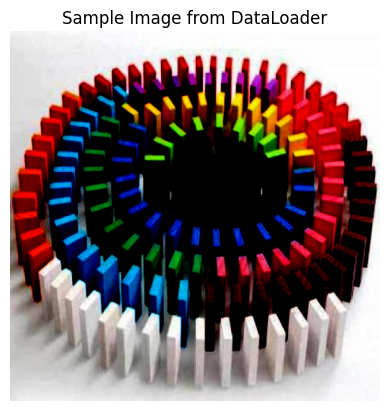

In [9]:
import matplotlib.pyplot as plt

# Get a batch of images from the DataLoader
images = next(iter(dataloader))

# Select the first image in the batch
image = images[7].cpu().numpy().squeeze()
image = image.transpose(1, 2, 0)
# Display the image
plt.imshow(image, cmap='gray')
plt.title("Sample Image from DataLoader")
plt.axis('off')
plt.show()

In [26]:
target_128 = F.interpolate(images, size=(128, 128), mode='bilinear', align_corners=False)
target_256 = F.interpolate(images, size=(256, 256), mode='bilinear', align_corners=False)
target_128.shape

torch.Size([16, 3, 128, 128])

In [17]:
import torch
from torch import nn
from torch.optim import Adam

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder_mrl = AutoEncoderMRL().to(device)

optimizer = Adam(autoencoder_mrl.parameters(), lr=1e-3)

mrl_weights = [1, 1, 1]  # Weights for 128x128, 256x256, and 512x512 resolutions

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    autoencoder_mrl.train()  # Set model to training mode
    total_loss = 0

    for images in dataloader:  # Iterate over batches from the DataLoader
        images = images.to(device)  # Move images to the GPU/CPU

        out_128, out_256, out_512, _ = autoencoder_mrl(images)  # Outputs at 128x128, 256x256, 512x512

        loss = mrl_loss((out_128, out_256, out_512), images, mrl_weights)

        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update model weights
        total_loss += loss.item()

    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/15], Loss: 0.8511
Epoch [2/15], Loss: 0.6292
Epoch [3/15], Loss: 0.6074
Epoch [4/15], Loss: 0.5998
Epoch [5/15], Loss: 0.5983
Epoch [6/15], Loss: 0.5973
Epoch [7/15], Loss: 0.5984
Epoch [8/15], Loss: 0.5935
Epoch [9/15], Loss: 0.6227
Epoch [10/15], Loss: 0.5942
Epoch [11/15], Loss: 0.5928
Epoch [12/15], Loss: 0.5927
Epoch [13/15], Loss: 0.6069
Epoch [14/15], Loss: 0.5944
Epoch [15/15], Loss: 0.5941


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


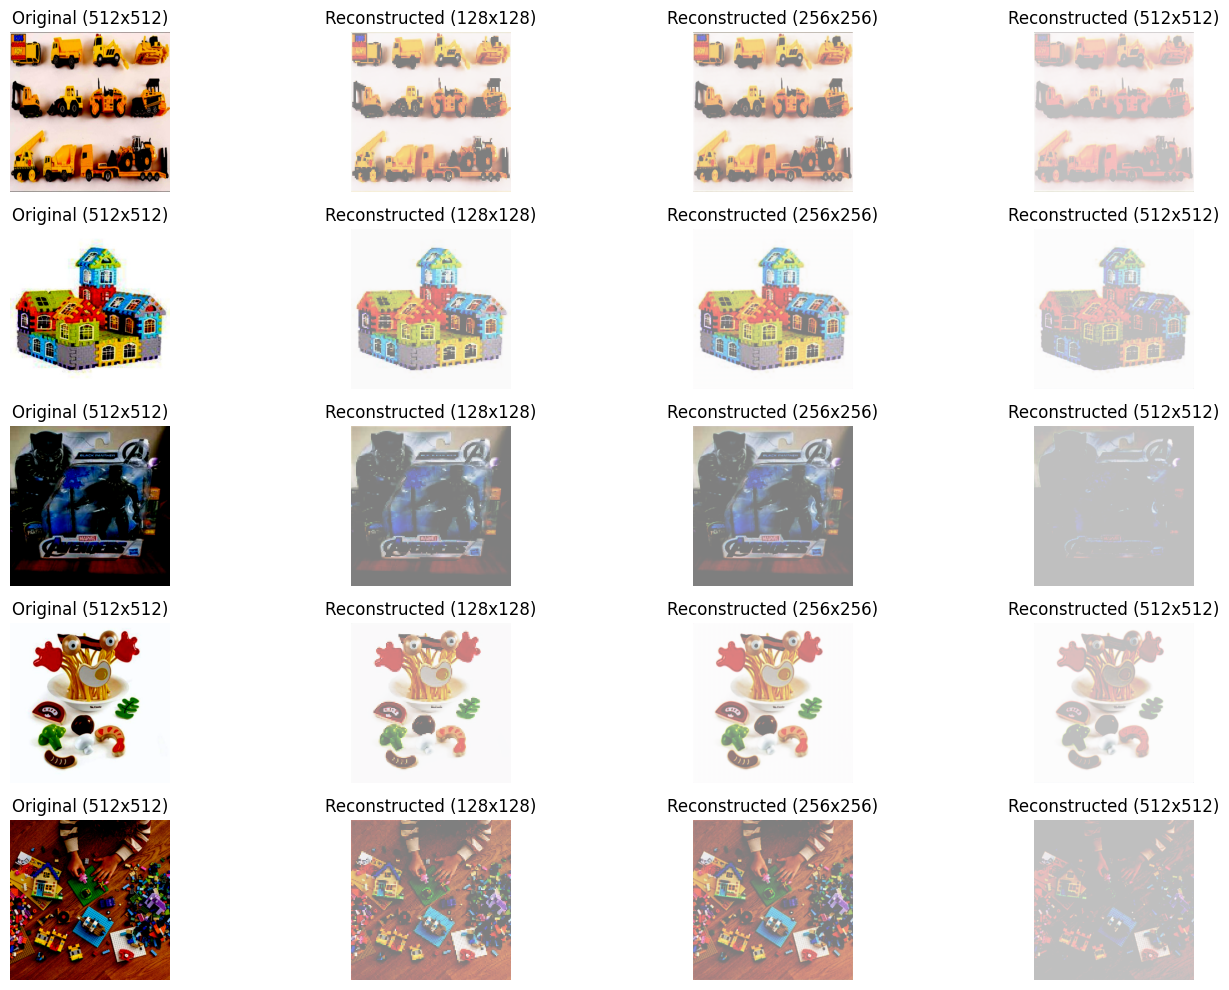

In [27]:
import matplotlib.pyplot as plt

# Set model to evaluation mode
autoencoder_mrl.eval()

# Get a batch of images from the dataloader
images = next(iter(dataloader))
images = images.to(device)

# Run inference
with torch.no_grad():
    out_128, out_256, out_512, _ = autoencoder_mrl(images)

# Move images and outputs back to CPU for visualization
images = images.cpu().numpy()
out_128 = out_128.cpu().numpy()
out_256 = out_256.cpu().numpy()
out_512 = out_512.cpu().numpy()

# # Function to denormalize images (from [-1, 1] to [0, 1])
def denormalize(tensor):
    return (tensor * 0.5) + 0.5

# Denormalize the images and outputs
# images = denormalize(images)  # Original images
out_128 = denormalize(out_128)  # Reconstructed 128x128
out_256 = denormalize(out_256)  # Reconstructed 256x256
out_512 = denormalize(out_512)  # Reconstructed 512x512

# Visualize the images
plt.figure(figsize=(15, 10))

for i in range(5):  # Visualize 5 images
    # Original image
    plt.subplot(5, 4, i * 4 + 1)
    plt.imshow(images[i].transpose(1, 2, 0))  # Convert CHW -> HWC
    plt.title("Original (512x512)")
    plt.axis('off')

    # Reconstructed 128x128
    plt.subplot(5, 4, i * 4 + 2)
    plt.imshow(out_128[i].transpose(1, 2, 0))  # Convert CHW -> HWC
    plt.title("Reconstructed (128x128)")
    plt.axis('off')

    # Reconstructed 256x256
    plt.subplot(5, 4, i * 4 + 3)
    plt.imshow(out_256[i].transpose(1, 2, 0))  # Convert CHW -> HWC
    plt.title("Reconstructed (256x256)")
    plt.axis('off')

    # Reconstructed 512x512
    plt.subplot(5, 4, i * 4 + 4)
    plt.imshow(out_512[i].transpose(1, 2, 0))  # Convert CHW -> HWC
    plt.title("Reconstructed (512x512)")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [24]:
images[1] - out_512[1]

array([[[ 0.0716818 ,  0.03575861,  0.04667968, ...,  0.0119915 ,
          0.04080349,  0.08686787],
        [ 0.05944604,  0.02514303,  0.01870859, ...,  0.00535184,
          0.00793451,  0.05227447],
        [ 0.04703218,  0.01617551,  0.02549154, ...,  0.00403666,
          0.01768404,  0.05270982],
        ...,
        [ 0.02830756,  0.00543803,  0.00513572, ..., -1.3196079 ,
         -1.1392157 , -1.0921569 ],
        [ 0.05471039,  0.01413363,  0.02449697, ..., -1.2411765 ,
         -1.1       , -1.0294118 ],
        [ 0.11924809,  0.0536797 ,  0.06576645, ..., -1.1705883 ,
         -1.1078432 , -0.99019605]],

       [[ 0.11843127,  0.03090447,  0.04314697, ...,  0.01387817,
          0.04268813,  0.0478363 ],
        [ 0.02553082,  0.01354396,  0.02595478, ...,  0.00893325,
          0.01185083,  0.04211235],
        [ 0.03908545,  0.00610274,  0.04579306, ...,  0.00702149,
          0.02094442,  0.03106129],
        ...,
        [ 0.0070101 ,  0.00302219,  0.00894368, ..., -

In [31]:
# Calculate reconstruction loss on the test dataset for the MRL autoencoder
autoencoder_mrl.eval()
total_loss = 0

folder_path = 'toys/test'

# Dataset and DataLoader setup
dataset_test = ImageDataset(folder_path, transform=transform)  # Using the same transform as training
batch_size = 16
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Loss weights for different resolutions
weights = [1.0, 0.5, 0.1]  # Example weights for MRL loss

with torch.no_grad():
    for images in dataloader_test:  
        images = images.to(device)
        
        # Forward pass through the autoencoder
        out_128, out_256, out_512, _ = autoencoder_mrl(images)
        
        # Downsample original images to match resolutions
        target_128 = F.interpolate(images, size=(128, 128), mode='bilinear', align_corners=False)
        target_256 = F.interpolate(images, size=(256, 256), mode='bilinear', align_corners=False)
        
        # Compute losses for each resolution
        loss_128 = nn.MSELoss()(out_128, target_128)
        loss_256 = nn.MSELoss()(out_256, target_256)
        loss_512 = nn.MSELoss()(out_512, images)
        
        # Weighted sum of losses
        loss = weights[0] * loss_128 + weights[1] * loss_256 + weights[2] * loss_512
        total_loss += loss.item()

# Calculate average loss
average_loss = total_loss / len(dataloader_test)
print(f"Reconstruction Loss (MRL MSE): {average_loss:.4f}")


Reconstruction Loss (MRL MSE): 0.2479


In [32]:
# Calculate reconstruction loss on the test dataset for AutoEncoderMRL
autoencoder_mrl.eval()
total_loss = 0

# Define the path to the test dataset
folder_path = 'toys/test'

# Create the test dataset and dataloader
dataset_test = ImageDataset(folder_path, transform=transform)  # Using the same transform as training
batch_size = 16
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Define weights for MRL loss (you can adjust these as needed)
mrl_weights = [0.2, 0.3, 0.5]

# Evaluate the model on the test dataset
with torch.no_grad():  # Disable gradient calculation
    for images in dataloader_test:
        images = images.to(device)  # Move images to the GPU/CPU

        # Forward pass through the model
        out_128, out_256, out_512, _ = autoencoder_mrl(images)

        # Compute the multi-resolution loss
        loss = mrl_loss((out_128, out_256, out_512), images, mrl_weights)
        total_loss += loss.item()  # Accumulate the total loss

# Calculate average loss across all batches
average_loss = total_loss / len(dataloader_test)
print(f"Reconstruction Loss (MRL): {average_loss:.4f}")


Reconstruction Loss (MRL): 0.2806


In [6]:
def train_autoencoder():
    # Dataset and DataLoader setup
    data_transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])

    dataset = datasets.ImageFolder(root="toys/train", transform=data_transform)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

    # Model, optimizer, and loss function
    model = AutoEncoderMRL()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    weights = [1.0, 0.5, 0.1]  # Example weights for MRL loss

    # Training loop
    num_epochs = 10
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_idx, (inputs, _) in enumerate(dataloader):
            inputs = inputs.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            model = model.to(inputs.device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = mrl_loss(outputs[:3], inputs, weights)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(dataloader):.4f}")

    # Save trained model
    torch.save(model.state_dict(), "autoencoder_mrl.pth")